In [ ]:
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import random
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
from efficientnet_pytorch import EfficientNet
from collections import Counter


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr 18 09:37:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Siamese Dataset

In [ ]:
class SiameseDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_cases=5):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.image_reference = []
        for subject in os.listdir(root_dir):
            subject_path = os.path.join(root_dir, subject)
            if os.path.isdir(subject_path):
                for image_name in os.listdir(subject_path):
                    image_path = os.path.join(subject_path, image_name)

                    same_subject_paths = np.array([path for path in os.listdir(subject_path) if path != image_name])
                    num_images = len(same_subject_paths)

                    possible_diff_subjs = [path for path in os.listdir(root_dir) if path != subject_path]
                    diff_subjects = np.random.choice(np.array(possible_diff_subjs), num_images, replace=True)
                    diff_subject_selection = np.array([np.random.choice(os.listdir(root_dir + "/" + subject), 1) for subject in diff_subjects])
                    
                    for image_same, image_diff, diff_subj in zip(same_subject_paths, diff_subject_selection, diff_subjects):
                      # Same image label = 1
                      image_same_full_path = os.path.join(root_dir, subject, image_same)
                      self.image_reference.append(image_path)
                      self.image_paths.append(image_same_full_path)
                      self.labels.append(1)

                      # Different image label = 0
                      image_diff_full_path = os.path.join(root_dir, diff_subj, image_diff[0])
                      self.image_reference.append(image_path)
                      self.image_paths.append(image_diff_full_path)
                      self.labels.append(0)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_compare_path = self.image_paths[index]
        image_reference_path = self.image_reference[index]
        label = self.labels[index]
        image_comp = Image.open(image_compare_path).convert("RGB")
        image_ref = Image.open(image_reference_path).convert("RGB")
        if self.transform:
            image_comp = self.transform(image_comp)
            image_ref  = self.transform(image_ref)
        return image_comp, image_ref, label


class SiameseDatasetImproved(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.image_reference = []
        
        subjects = [subj for subj in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, subj))]
        
        for subject in subjects:
            subject_path = os.path.join(root_dir, subject)
            subject_images = os.listdir(subject_path)
            
            for image_name in subject_images:
                image_path = os.path.join(subject_path, image_name)

                # Positive pairs (same subject)
                same_subject_images = [img for img in subject_images if img != image_name]
                num_images = len(same_subject_images)
                for same_subject_image in same_subject_images:
                    same_subject_image_path = os.path.join(subject_path, same_subject_image)
                    self.image_reference.append(image_path)
                    self.image_paths.append(same_subject_image_path)
                    self.labels.append(1)

                # Negative pairs (different subjects)
                subjects_except_current = [subj for subj in subjects if subj != subject]
                diff_subjects = np.random.choice(subjects_except_current, num_images)
                
                for diff_subject in diff_subjects:
                    diff_subject_path = os.path.join(root_dir, diff_subject)
                    diff_subject_image = np.random.choice(os.listdir(diff_subject_path), 1)[0]
                    diff_subject_image_path = os.path.join(diff_subject_path, diff_subject_image)
                    self.image_reference.append(image_path)
                    self.image_paths.append(diff_subject_image_path)
                    self.labels.append(0)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_compare_path = self.image_paths[index]
        image_reference_path = self.image_reference[index]
        label = self.labels[index]
        image_comp = Image.open(image_compare_path).convert("RGB")
        image_ref = Image.open(image_reference_path).convert("RGB")
        
        if self.transform:
            image_comp = self.transform(image_comp)
            image_ref = self.transform(image_ref)
        
        return image_comp, image_ref, label

In [ ]:
train_imgs_path = "/content/drive/MyDrive/ULTRADATA/Motos_reencuadradas/Train"
test_imgs_path  = "/content/drive/MyDrive/ULTRADATA/Motos_reencuadradas/Test"

img_size = 224

if train_imgs_path == "/content/drive/MyDrive/ULTRADATA/Motos100x100preproc/Train":
  transform_train = transforms.Compose([
      transforms.ToTensor(), 
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ## ONLY FOR EFFICIENTNET!!
  ])
  transform_valid = transforms.Compose([
      transforms.ToTensor(), 
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ## ONLY FOR EFFICIENTNET!!
  ])

else:
  # Define the transforms we want to apply to the images

  transform_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # , transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
  ])

  transform_valid = transforms.Compose([
      transforms.Resize((img_size, img_size)), # transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

siamese_train_dataset = SiameseDatasetImproved(root_dir=train_imgs_path, transform=transform_train)
siamese_test_dataset = SiameseDatasetImproved(root_dir=test_imgs_path, transform=transform_valid)

Verificando que haya la cantidad correcta de imagenes. Deberían haber 10 imágenes (5 iguales y 5 diferentes) por cada una de las imágenes de la carpeta. Entonces deberían ser 2900 para las 290 que hay.

In [ ]:
siamese_train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
len(siamese_train_dataset.image_paths)

8428

In [ ]:
sum(siamese_train_dataset.labels) / len(siamese_train_dataset.labels)

0.5

In [ ]:
# Count number of labels
print(Counter(siamese_train_dataset.labels))

Counter({1: 4214, 0: 4214})


In [ ]:
conteo = 0
base_path = "/content/drive/MyDrive/ULTRADATA/Motos/Train"
for elem in os.listdir(base_path):
  foto_path = base_path + f"/{elem}"

  conteo += len(os.listdir(foto_path))

print(conteo)

290


In [ ]:
batch_size = 32
shuffle = True
num_workers = 2

siamese_train_dataloader = DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
siamese_val_dataloader   = DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

In [ ]:
len(siamese_train_dataset)

8428

## Debugging the DataLoader

In [ ]:
for data in siamese_train_dataloader:
  img0, img1, labels = data
  break

In [ ]:
labels

tensor([1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 0])

In [ ]:
def unnormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [ ]:
def imshow(img):
    img = unnormalize(img)
    # img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

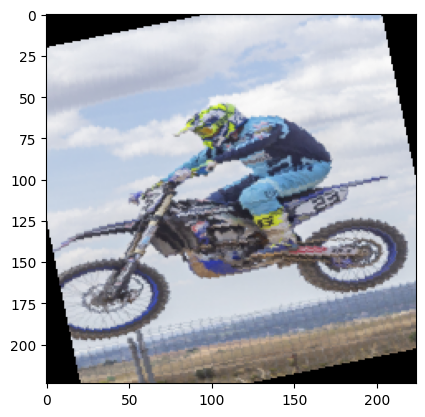

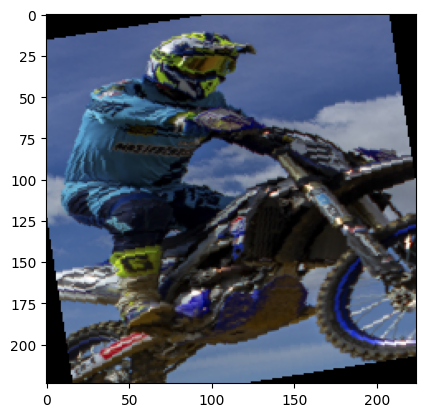

tensor(1)


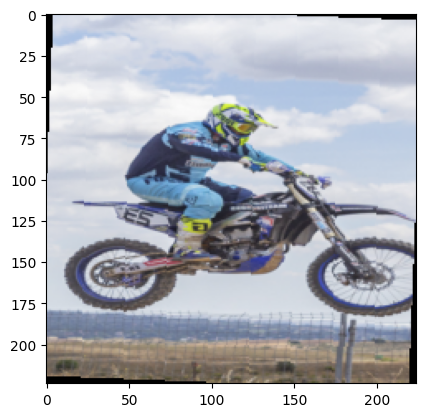

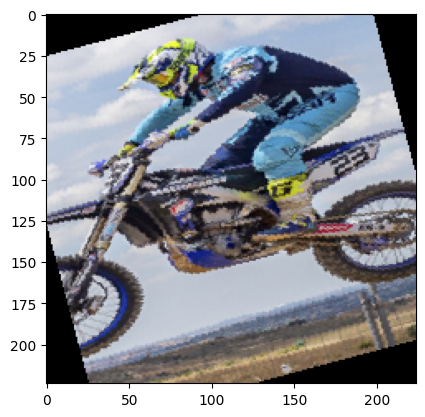

tensor(1)


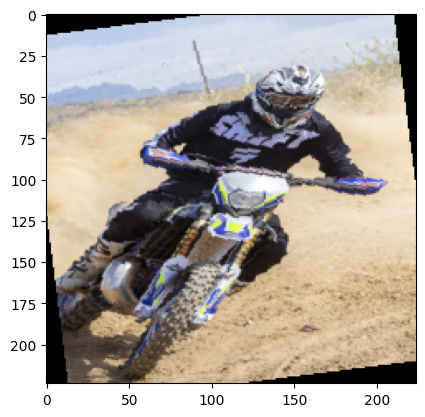

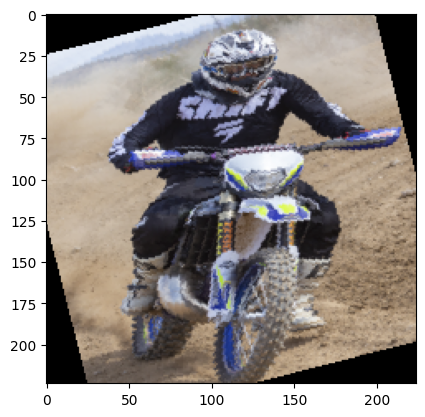

tensor(1)


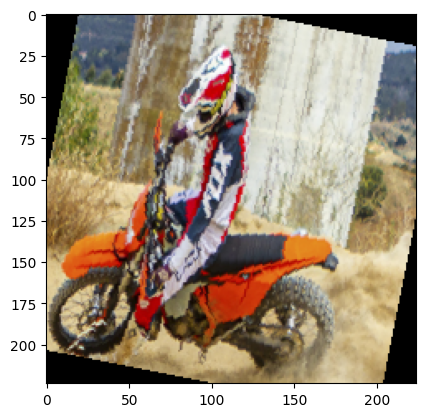

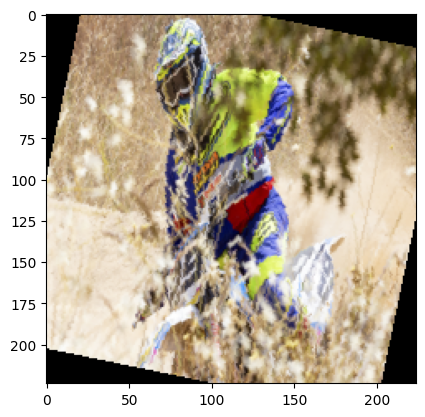

tensor(0)


In [ ]:
for idx in range(4):
  # idx = 5

  image_0 = img0[idx, :, :, :]
  image_1 = img1[idx, :, :, :]
  label = labels[idx]

  imshow(image_0)
  imshow(image_1)
  print(label)

## Simple CNN for testing

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, init_method):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2) # [16, 224, 224]
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # [16, 112, 112]
        
        self.conv2 = nn.Conv2d(8, 32, kernel_size=5, stride=1, padding=2) # [32, 112, 112]
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # [32, 56, 56]
        
        self.fc1 = nn.Linear(32 * 56 * 56, 1024) # self.fc1 = nn.Linear(32 * 56 * 56, 1024)
        self.relu3 = nn.ReLU()
        
        self.fc2 = nn.Linear(1024, 128) # self.fc2 = nn.Linear(1024, 256)

        self._initialize_weights(init_method)

    def _initialize_weights(self, init_method):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if init_method == 'xavier':
                    init.xavier_uniform_(m.weight)
                elif init_method == 'he':
                    init.kaiming_uniform_(m.weight, nonlinearity='relu')
                elif init_method == 'random':
                    init.uniform_(m.weight, a=-0.1, b=0.1)
                init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                init.ones_(m.weight)
                init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                if init_method == 'xavier':
                    init.xavier_uniform_(m.weight)
                elif init_method == 'he':
                    init.kaiming_uniform_(m.weight, nonlinearity='relu')
                elif init_method == 'random':
                    init.uniform_(m.weight, a=-0.1, b=0.1)
                init.zeros_(m.bias)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 32 * 25 * 25) # x = x.view(-1, 32 * 56 * 56)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

class SimpleCNNwBatchNorm(nn.Module):
    def __init__(self, use_batch_norm, init_method):
        super(SimpleCNNwBatchNorm, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(8) if use_batch_norm else None
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(16) if use_batch_norm else None
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(16 * 25 * 25, 512) # self.fc1 = nn.Linear(32 * 56 * 56, 1024)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(512, 128) # self.fc2 = nn.Linear(1024, 256)

        self._initialize_weights(init_method)

    def _initialize_weights(self, init_method):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if init_method == 'xavier':
                    init.xavier_uniform_(m.weight)
                elif init_method == 'he':
                    init.kaiming_uniform_(m.weight, nonlinearity='relu')
                elif init_method == 'random':
                    init.uniform_(m.weight, a=-0.1, b=0.1)
                init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                init.ones_(m.weight)
                init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                if init_method == 'xavier':
                    init.xavier_uniform_(m.weight)
                elif init_method == 'he':
                    init.kaiming_uniform_(m.weight, nonlinearity='relu')
                elif init_method == 'random':
                    init.uniform_(m.weight, a=-0.1, b=0.1)
                init.zeros_(m.bias)

    def forward(self, x):
        x = self.conv1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(self.relu1(x))

        x = self.conv2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(self.relu2(x))

        x = x.view(-1, 16 * 25 * 25) # x = x.view(-1, 32 * 56 * 56)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x


class EfficientNetFeatureExtractor(nn.Module):
    def __init__(self, model_name='efficientnet-b0', pretrained=True):
        super(EfficientNetFeatureExtractor, self).__init__()
        self.efficient_net = EfficientNet.from_pretrained(model_name) if pretrained else EfficientNet.from_name(model_name)

        # Get the number of output features from the EfficientNet model
        num_output_features = self.efficient_net._fc.in_features

        # Remove the classification head to use it as a feature extractor
        self.efficient_net._fc = nn.Identity()

        # Define the fully connected layer with the appropriate input size
        self.fc = nn.Linear(num_output_features, 128)  # 128

        # Add a normalization layer
        self.norm = nn.BatchNorm1d(128)  # 128

        # Freeze the pre-trained EfficientNet model parameters
        for param in self.efficient_net.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.efficient_net(x)
        x = self.fc(x)
        x = self.norm(x)
        return x


class SiameseNetwork(nn.Module):
    def __init__(self, feature_extractor, model_name, init_method, batch_norm, learning_rate, epochs, dataset,	loss_function, accuracy_threshold, img_size):
        super(SiameseNetwork, self).__init__()
        self.feature_extractor = feature_extractor

        # Define parameters for saving:
        self.name = model_name
        self.init_method = init_method
        self.batch_norm = batch_norm
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.dataset = dataset
        self.loss_function = loss_function
        self.img_size = img_size

    def forward(self, x1, x2):
        output1 = self.feature_extractor(x1)
        output2 = self.feature_extractor(x2)
        return output1, output2


def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def unfreeze_layers(model, num_layers_to_unfreeze):
    ct = 0
    children_list = list(model.children())
    for child in reversed(children_list):
        ct += 1
        if ct <= num_layers_to_unfreeze:
            for param in child.parameters():
                param.requires_grad = True
        else:
            break


# Instantiate the Siamese network, loss function, and optimizer
# init_method = "random"
# batch_norm = True
# feature_extractor = SimpleCNNwBatchNorm(init_method=init_method, use_batch_norm=batch_norm)

feature_extractor = EfficientNetFeatureExtractor(model_name='efficientnet-b0', pretrained=True)

siamese_network = SiameseNetwork(
    feature_extractor=feature_extractor, model_name="EfficientNetFeatureExtractor", init_method="N/A", batch_norm=True, learning_rate=0.0001, 
    epochs=10, dataset="Motos", loss_function="contrastive", accuracy_threshold=0.5, img_size=img_size
)

num_layers_to_unfreeze = 1
unfreeze_layers(siamese_network.feature_extractor.efficient_net, num_layers_to_unfreeze)

n_params = count_trainable_parameters(siamese_network)
print(f"Model's trainable parameters: {n_params}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
siamese_network.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 353MB/s]


Loaded pretrained weights for efficientnet-b0
Model's trainable parameters: 164224


SiameseNetwork(
  (feature_extractor): EfficientNetFeatureExtractor(
    (efficient_net): EfficientNet(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32, kernel_size=(1, 1), stride=(1, 

## Create Loss Function

In [ ]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

loss_function = ContrastiveLoss()
if isinstance(siamese_network.feature_extractor, EfficientNetFeatureExtractor):
  optimizer = optim.Adam(filter(lambda p: p.requires_grad, siamese_network.parameters()), lr=siamese_network.learning_rate)
else:
  optimizer = optim.Adam(siamese_network.parameters(), lr=siamese_network.learning_rate)

## Create Accuracy Function for easier testing

In [ ]:
def compute_accuracy(output1, output2, labels, threshold=0.5):
    euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
    predictions = (euclidean_distance > threshold).float()
    accuracy = (predictions == labels.float()).float().mean()
    return accuracy.item()

def compute_best_threshold_and_auc(output1, output2, labels):
    euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
    distances = euclidean_distance.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    # Compute the AUC score
    auc_score = roc_auc_score(labels, distances)

    # Compute the ROC curve and find the best threshold
    fpr, tpr, thresholds = roc_curve(labels, distances)
    optimal_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[optimal_idx]

    return best_threshold, auc_score


## Create training loop

In [ ]:
epochs = siamese_network.epochs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Assuming you have a validation DataLoader named val_dataloader
for epoch in range(epochs):
    # Training loop
    siamese_network.train()
    train_loss = 0.0
    train_accuracy = 0.0
    for batch, (image_comp, image_ref, label) in tqdm(enumerate(siamese_train_dataloader), total=len(siamese_train_dataloader), desc="Training"):
        image1, image2 = image_comp, image_ref
        label = label.to(device)

        image1 = image1.to(device)
        image2 = image2.to(device)

        output1, output2 = siamese_network(image1, image2)
        loss = loss_function(output1, output2, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_accuracy += compute_accuracy(output1, output2, label)

    train_loss /= len(siamese_train_dataloader)
    train_accuracy /= len(siamese_train_dataloader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    siamese_network.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.inference_mode():
        for batch, (image_comp, image_ref, label) in tqdm(enumerate(siamese_val_dataloader), total=len(siamese_val_dataloader), desc="Validation"):
            image1, image2 = image_comp, image_ref
            label = label.to(device)

            image1 = image1.to(device)
            image2 = image2.to(device)

            output1, output2 = siamese_network(image1, image2)
            loss = loss_function(output1, output2, label)

            val_loss += loss.item()
            val_accuracy += compute_accuracy(output1, output2, label)

    val_loss /= len(siamese_val_dataloader)
    val_accuracy /= len(siamese_val_dataloader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f" --> Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Validation: 100%|██████████| 6/6 [00:00<00:00, 10.44it/s]

 --> Epoch: 0, Train Loss: 57.3387, Train Accuracy: 0.5000, Val Loss: 10.4414, Val Accuracy: 0.5000



Validation: 100%|██████████| 6/6 [00:00<00:00, 10.41it/s]

 --> Epoch: 1, Train Loss: 2.9756, Train Accuracy: 0.5001, Val Loss: 6.9867, Val Accuracy: 0.5000



Validation: 100%|██████████| 6/6 [00:00<00:00,  9.99it/s]

 --> Epoch: 2, Train Loss: 1.5557, Train Accuracy: 0.4999, Val Loss: 5.4854, Val Accuracy: 0.4896



Validation: 100%|██████████| 6/6 [00:00<00:00, 10.69it/s]

 --> Epoch: 3, Train Loss: 1.1958, Train Accuracy: 0.4998, Val Loss: 5.0917, Val Accuracy: 0.5000



Validation: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]

 --> Epoch: 4, Train Loss: 1.0920, Train Accuracy: 0.5001, Val Loss: 4.7936, Val Accuracy: 0.4896



Validation: 100%|██████████| 6/6 [00:00<00:00, 10.30it/s]

 --> Epoch: 5, Train Loss: 1.0573, Train Accuracy: 0.4992, Val Loss: 4.5239, Val Accuracy: 0.4948



Validation: 100%|██████████| 6/6 [00:00<00:00,  9.00it/s]

 --> Epoch: 6, Train Loss: 1.0426, Train Accuracy: 0.4993, Val Loss: 4.5979, Val Accuracy: 0.5000



Validation: 100%|██████████| 6/6 [00:00<00:00,  7.29it/s]

 --> Epoch: 7, Train Loss: 1.0403, Train Accuracy: 0.4992, Val Loss: 4.4233, Val Accuracy: 0.5000



Validation: 100%|██████████| 6/6 [00:00<00:00,  6.91it/s]

 --> Epoch: 8, Train Loss: 1.0369, Train Accuracy: 0.4989, Val Loss: 4.4682, Val Accuracy: 0.4948



Validation: 100%|██████████| 6/6 [00:00<00:00,  9.17it/s]

 --> Epoch: 9, Train Loss: 1.0374, Train Accuracy: 0.5001, Val Loss: 4.3197, Val Accuracy: 0.5000


## Overfitting Testing

In [ ]:
siamese_network = siamese_network.cuda()
img0, img1 = img0.cuda(), img1.cuda()
labels = labels.cuda()

optimizer = optim.Adam(siamese_network.parameters(), lr=0.001)

for i in range(1000):
  output1, output2 = siamese_network(img0, img1)
  loss = loss_function(output1, output2, labels)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  accuracy = compute_accuracy(output1, output2, labels)

  print(f"Epoch: {i + 1} | Acc: {accuracy} | loss: {loss.item()}")

Epoch: 1 | Acc: 0.46875 | loss: 132.44879150390625
Epoch: 2 | Acc: 0.46875 | loss: 106.06024932861328
Epoch: 3 | Acc: 0.46875 | loss: 85.5087890625
Epoch: 4 | Acc: 0.46875 | loss: 68.92996215820312
Epoch: 5 | Acc: 0.46875 | loss: 60.817264556884766
Epoch: 6 | Acc: 0.46875 | loss: 53.31325149536133
Epoch: 7 | Acc: 0.46875 | loss: 43.596519470214844
Epoch: 8 | Acc: 0.46875 | loss: 39.24838638305664
Epoch: 9 | Acc: 0.46875 | loss: 37.47368621826172
Epoch: 10 | Acc: 0.46875 | loss: 33.937904357910156
Epoch: 11 | Acc: 0.46875 | loss: 33.870765686035156
Epoch: 12 | Acc: 0.46875 | loss: 29.491668701171875
Epoch: 13 | Acc: 0.46875 | loss: 24.973506927490234
Epoch: 14 | Acc: 0.46875 | loss: 25.202945709228516
Epoch: 15 | Acc: 0.46875 | loss: 24.190635681152344
Epoch: 16 | Acc: 0.46875 | loss: 21.749387741088867
Epoch: 17 | Acc: 0.46875 | loss: 22.248384475708008
Epoch: 18 | Acc: 0.46875 | loss: 22.380672454833984
Epoch: 19 | Acc: 0.46875 | loss: 21.912202835083008
Epoch: 20 | Acc: 0.46875 | los

In [ ]:
accuracy

0.59375

In [ ]:
euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2, keepdim = True)

predictions = (euclidean_distance.cuda() > 0.5).float()
accuracy = (predictions == labels.cuda().float()).float().mean()

predictions, labels

(tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.]], device='cuda:0'),
 tensor([0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
         0, 1, 1, 0, 1, 1, 0, 1], device='cuda:0'))

In [ ]:
df = pd.DataFrame({"euclidean_distance": euclidean_distance.cpu().detach().numpy().reshape(32), "labels": labels.cpu().detach().numpy()})

df.groupby('labels').mean()

,euclidean_distance
labels,
0,10.139650
1,11.489694


In [ ]:
df

,euclidean_distance,labels
0,11.030743,0
1,6.942639,0
2,7.094099,1
3,10.407022,0
4,23.632320,1
5,8.502895,0
6,17.033070,1
7,8.843085,1
8,9.050701,0
9,10.374493,0


In [ ]:
torch.mean(labels.float())

tensor(0.5938, device='cuda:0')

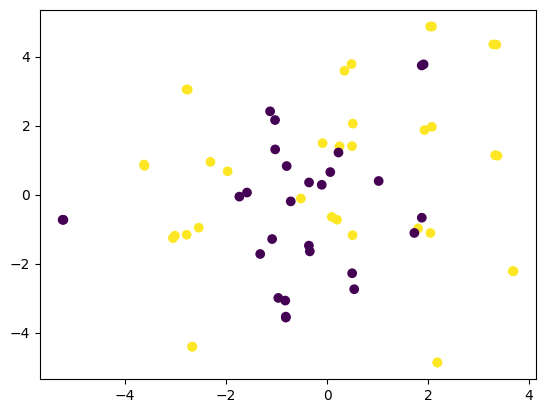

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

img0, img1 = img0.cuda(), img1.cuda()
# Get the embeddings for a batch of data
output1, output2 = siamese_network(img0, img1)

# Concatenate the embeddings and labels
embeddings = torch.cat((output1, output2), 0)
labels2 = torch.cat((labels, labels), 0)
labels2 = labels2.detach().cpu().numpy()

# Convert the embeddings to numpy
embeddings = embeddings.detach().cpu().numpy()

# Perform t-SNE
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the results
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels2[:64])
plt.show()

In [ ]:
siamese_network = siamese_network.cuda()
img0, img1 = img0.cuda(), img1.cuda()

with torch.inference_mode():
  output1, output2 = siamese_network(img0, img1)

output1

tensor([[-0.0627, -0.2628,  0.2814,  ..., -0.1362, -0.0280, -0.0738],
        [-0.2177, -0.1907,  0.0226,  ..., -0.1788,  0.1118, -0.1609],
        [-0.1485, -0.2413,  0.2580,  ..., -0.1501,  0.0416, -0.1827],
        ...,
        [-0.0882, -0.1470,  0.2457,  ..., -0.2239,  0.3210, -0.0395],
        [-0.2932, -0.3681,  0.3167,  ...,  0.0692,  0.5137, -0.2083],
        [-0.3024, -0.1024,  0.0713,  ..., -0.1503,  0.2023, -0.1849]],
       device='cuda:0')

In [ ]:
output2

tensor([[-0.0876, -0.1419,  0.4440,  ..., -0.2156,  0.0377, -0.1063],
        [-0.2001, -0.1903, -0.1826,  ..., -0.1592,  0.1636, -0.1225],
        [-0.1295, -0.3021,  0.3425,  ..., -0.2201, -0.0894, -0.1688],
        ...,
        [-0.1119, -0.0273,  0.1933,  ..., -0.2962,  0.4640,  0.0776],
        [-0.5389, -0.3924,  0.1334,  ...,  0.0718,  0.5468, -0.1491],
        [-0.4641, -0.2723,  0.1577,  ..., -0.0738,  0.4309, -0.1857]],
       device='cuda:0')

In [ ]:
output1.shape

torch.Size([32, 128])

In [ ]:
len(torch.nn.functional.pairwise_distance(output1, output2, keepdim = True))

32

In [ ]:
euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2, keepdim = True)

predictions = (euclidean_distance.cuda() > 0.5).float()
accuracy = (predictions == labels.cuda().float()).float().mean()

predictions, labels

(tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.]], device='cuda:0'),
 tensor([1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
         0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0'))

In [ ]:
accuracy

tensor(0.5625, device='cuda:0')

In [ ]:
df = pd.DataFrame({"euclidean_distance": euclidean_distance.cpu().reshape(32), "labels": labels.cpu()})

df.groupby('labels').mean()

,euclidean_distance
labels,
0,1.255518
1,1.246300


In [ ]:
euclidean_distance

tensor([[1.0097],
        [1.1523],
        [1.0968],
        [1.4254],
        [1.1665],
        [1.3159],
        [1.0972],
        [1.5167],
        [1.0385],
        [1.3845],
        [1.0724],
        [1.4436],
        [1.1905],
        [1.2669],
        [1.1308],
        [1.0957],
        [1.2206],
        [1.0177],
        [1.1692],
        [1.1207],
        [1.2435],
        [2.1774],
        [1.1646],
        [1.0535],
        [1.2417],
        [1.0656],
        [1.5060],
        [1.2124],
        [1.1283],
        [1.5776],
        [1.4247],
        [1.2839]], device='cuda:0')

NameError: ignored

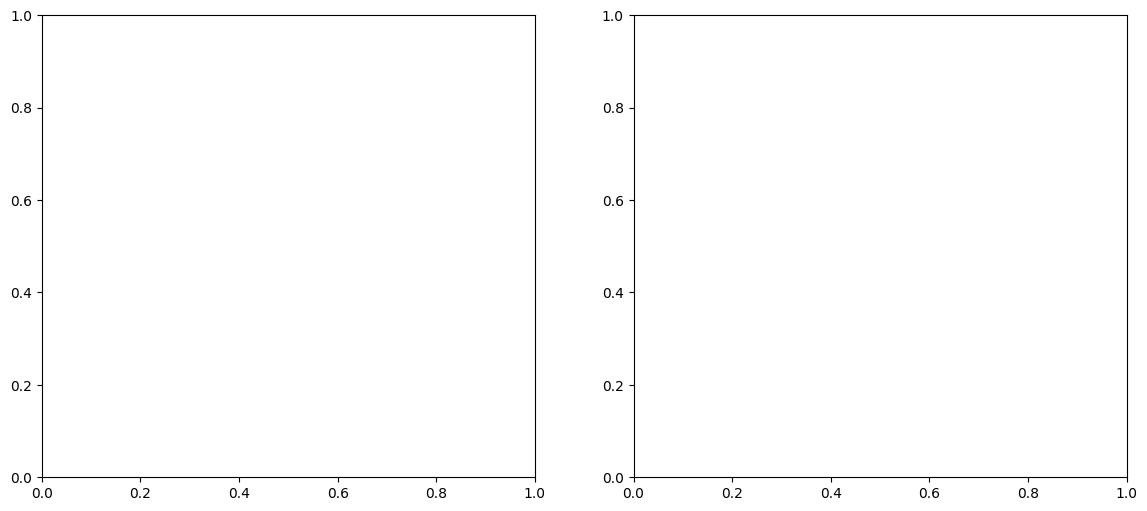

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

x = range(siamese_network.epochs)

ax[0].plot(x, train_losses, label="train loss")
ax[0].plot(x, val_losses, label="validation loss")
ax[0].legend()

ax[1].plot(x, train_accuracies, label="train loss")
ax[1].plot(x, val_accuracies, label="validation loss")
ax[1].legend()

In [ ]:
result_df = pd.DataFrame({
    "modelo": siamese_network.name, "dataset": siamese_network.dataset, "epochs": siamese_network.epochs, 
    "learning_rate": siamese_network.learning_rate, "batch_norm": siamese_network.batch_norm, "init_method": siamese_network.init_method, 
    "loss_function": siamese_network.loss_function, "best_training_loss": min(train_losses), "best_train_accuracy": max(train_accuracies) * 100, 
    "epoch_best_trainig": train_losses.index(min(train_losses)), "best_valid_loss": min(val_losses), 
    "best_valid_accuracy": max(val_accuracies) * 100, "epoch_best_valid": val_losses.index(min(val_losses)), 
    "train_losses": str(train_losses), "test_losses": str(val_losses)
}, index=[0])

result_df

In [ ]:
previous_results = pd.read_csv("/content/drive/MyDrive/ULTRADATA/model_results_file.csv", sep=";")

output_to_save = pd.concat([previous_results, result_df])

output_to_save

In [ ]:
output_to_save.to_csv("/content/drive/MyDrive/ULTRADATA/model_results_file.csv", sep=";", index=False)

## Testing performance on test set batch:

In [ ]:
for data in siamese_val_dataloader:
  ref_img_batch, cmp_img_batch, labels = data
  break

In [ ]:
idx = 6

image_0 = ref_img_batch[idx, :, :, :]
image_1 = cmp_img_batch[idx, :, :, :]
label = labels[idx]

imshow(image_0)
imshow(image_1)
print(label)

In [ ]:
image_0_for_model = image_0.unsqueeze(0).cuda()
image_1_for_model = image_1.unsqueeze(0).cuda()

test_output1, test_output2 = siamese_network(image_0_for_model, image_1_for_model)

euclidean_distance = torch.nn.functional.pairwise_distance(test_output1, test_output2)
prediction = (euclidean_distance < 0.5).float()

print(prediction)

In [ ]:
for data in siamese_train_dataloader:
  ref_img_batch, cmp_img_batch, labels = data
  break

In [ ]:
ref_img_batch, cmp_img_batch = ref_img_batch.cuda(), cmp_img_batch.cuda()

test_output1, test_output2 = siamese_network(ref_img_batch, cmp_img_batch)

euclidean_distances = torch.nn.functional.pairwise_distance(test_output1, test_output2)
predictions = (euclidean_distances < 0.5).float()

predictions

In [ ]:
labels

In [ ]:
euclidean_distances